<a href="https://colab.research.google.com/github/dianulka/computational-intelligence-in-digital-data-analysis/blob/main/project04/gymnsium2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame
import matplotlib.pyplot as plt

In [2]:
class SimpleMazeEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, render_mode=None):
        super(SimpleMazeEnv, self).__init__()

        self.grid_size = (10, 10)

        self.action_space = spaces.Discrete(4)

        self.observation_space = spaces.Box(low=0, high=max(self.grid_size)-1, shape=(2,), dtype=np.int32)

        self.grid = np.zeros(self.grid_size, dtype=int)

        self._generate_maze()
        self.agent_pos = [0, 0]

        self.render_mode = render_mode

    def _generate_maze(self):
        self.grid[:] = 0
        self.grid[9, 9] = 9  # cel

        # Ściany
        walls = [
            (1, 2), (2, 2), (3, 2),
            (5, 1), (5, 2), (5, 3),
            (6, 6), (7, 6), (8, 6),
            (3, 7), (4, 7), (5, 7)
        ]
        for x, y in walls:
            self.grid[x, y] = 1

        # 🔽🔽 ZADBAJ O TO, ŻEBY TE LINIE BYŁY NA KOŃCU 🔽🔽

        # Nagrody
        self.grid[4, 4] = 2
        self.grid[2, 6] = 2

        # Kary
        self.grid[5, 5] = 3
        self.grid[7, 3] = 3

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._generate_maze()  # <-- ważne!
        self.agent_pos = [0, 0]
        return np.array(self.agent_pos), {}

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:
            y = max(0, y - 1)
        elif action == 1:
            y = min(self.grid_size[1] - 1, y + 1)
        elif action == 2:
            x = max(0, x - 1)
        elif action == 3:
            x = min(self.grid_size[0] - 1, x + 1)

        if self.grid[x, y] == 1:
            x, y = self.agent_pos

        self.agent_pos = [x, y]
        reward = 0
        done = False

        tile = self.grid[x, y]
        if tile == 2:
            reward = 5
            self.grid[x, y] = 0
        elif tile == 3:
            reward = -2
        elif tile == 9:
            reward = 20
            done = True
        elif tile == 0:
            reward = -0.2  # puste pole

        return np.array(self.agent_pos), reward, done, False, {}

    def render(self, mode="human"):
        tile_size = 50
        width = self.grid_size[1] * tile_size
        height = self.grid_size[0] * tile_size

        if not hasattr(self, 'screen'):
            pygame.init()
            self.screen = pygame.display.set_mode((width, height))
            pygame.display.set_caption("Maze Agent")

        self.screen.fill((255, 255, 255))

        colors = {
            0: (255, 255, 255),
            1: (0, 0, 0),
            2: (0, 255, 0),
            3: (128, 0, 128),
            9: (255, 0, 0),
        }

        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                val = self.grid[i, j]
                color = colors.get(val, (200, 200, 200))
                pygame.draw.rect(self.screen, color, (j*tile_size, i*tile_size, tile_size, tile_size))

        ax, ay = self.agent_pos
        pygame.draw.rect(self.screen, (0, 0, 255), (ay*tile_size, ax*tile_size, tile_size, tile_size))
        print("Grid po starcie:\n", self.grid)
        pygame.display.flip()
        pygame.time.delay(100)

    def close(self):
        if hasattr(self, 'screen'):
            pygame.quit()


In [3]:
EPISODES = 500
ALPHA = 0.1
GAMMA = 0.99       # discount factor
EPSILON = 1.0      # exploration rate
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
MAX_STEPS = 200

In [4]:
env = SimpleMazeEnv()

q_table = np.zeros((env.grid_size[0], env.grid_size[1], env.action_space.n))

rewards_per_episode = []

for episode in range(EPISODES):
    steps = 0
    state, _ = env.reset()
    if (episode + 1) % 50 == 0:
        print(">>> Grid przed treningiem:")
        print(env.grid)

    done = False
    total_reward = 0

    recent_positions = []

    while not done and steps < MAX_STEPS:
        x, y = state

        if np.random.random() < EPSILON:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[x, y])

        next_state, reward, done, _, _ = env.step(action)

        # --- dodaj wykrywanie cykli ---
        recent_positions.append(tuple(next_state))
        if len(recent_positions) > 10:
            recent_positions.pop(0)

        if recent_positions.count(tuple(next_state)) > 4:
            reward -= 3  # kara za powtarzanie pozycji

        # --- Q-learning update ---
        nx, ny = next_state
        old_value = q_table[x, y, action]
        next_max = np.max(q_table[nx, ny])
        new_value = old_value + ALPHA * (reward + GAMMA * next_max - old_value)
        q_table[x, y, action] = new_value

        state = next_state
        total_reward += reward
        steps += 1

    EPSILON = max(EPSILON_MIN, EPSILON * EPSILON_DECAY)
    rewards_per_episode.append(total_reward)

    if (episode + 1) % 50 == 0:
        print(f"Epizod {episode + 1}, suma nagród: {total_reward:.2f}, epsilon: {EPSILON:.3f}")


def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


rolling_mean = moving_average(rewards_per_episode, 50)

>>> Grid przed treningiem:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 2 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 2 0 0 1 0 0]
 [0 1 1 1 0 3 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 3 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 9]]
Epizod 50, suma nagród: -56.60, epsilon: 0.778
>>> Grid przed treningiem:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 2 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 2 0 0 1 0 0]
 [0 1 1 1 0 3 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 3 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 9]]
Epizod 100, suma nagród: -13.60, epsilon: 0.606
>>> Grid przed treningiem:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 2 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 2 0 0 1 0 0]
 [0 1 1 1 0 3 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 3 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 9]]
Epizod 150, suma nagród: -19.00, epsilon: 0.471
>>> Grid przed treningiem:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 

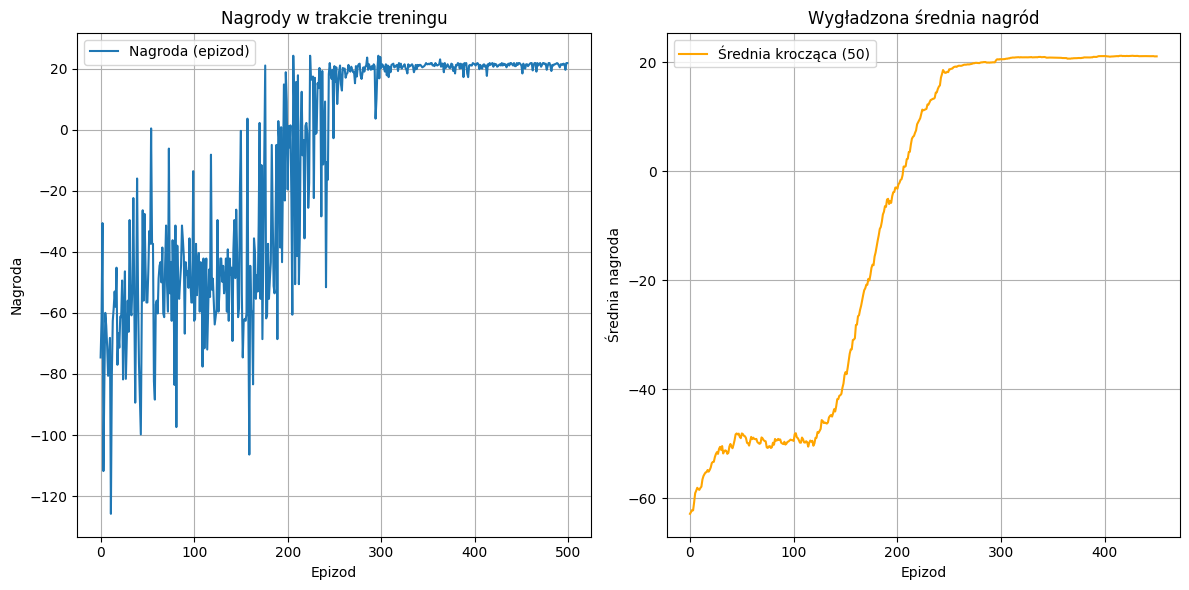

In [5]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rewards_per_episode, label='Nagroda (epizod)')
plt.title("Nagrody w trakcie treningu")
plt.xlabel("Epizod")
plt.ylabel("Nagroda")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rolling_mean, label='Średnia krocząca (50)', color='orange')
plt.title("Wygładzona średnia nagród")
plt.xlabel("Epizod")
plt.ylabel("Średnia nagroda")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
state, _ = env.reset()
done = False

while not done:
    env.render()
    x, y = state
    action = np.argmax(q_table[x, y])
    state, _, done, _, _ = env.step(action)

env.close()